# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Exploratory visualization of the dataset

Load the mapping of class id to class name

In [3]:
import pandas as pd
labels = pd.read_csv('signnames.csv')
labels.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def get_label(label_id):
    return labels[labels['ClassId']==label_id]['SignName'].tolist()[0]
    
def preview_data(images, label_ids, number_of_images=10):

    sample_idx = np.random.choice(images.shape[0], number_of_images)
    fig, axes = plt.subplots(math.ceil(len(sample_idx)/5), 5, figsize=(20,10))

    for idx, ax in zip(sample_idx, [b for a in axes for b in a]):
        ax.imshow(images[idx])
        ax.set_title(f'{get_label(label_ids[idx])} ({label_ids[idx]})')

Sample train images

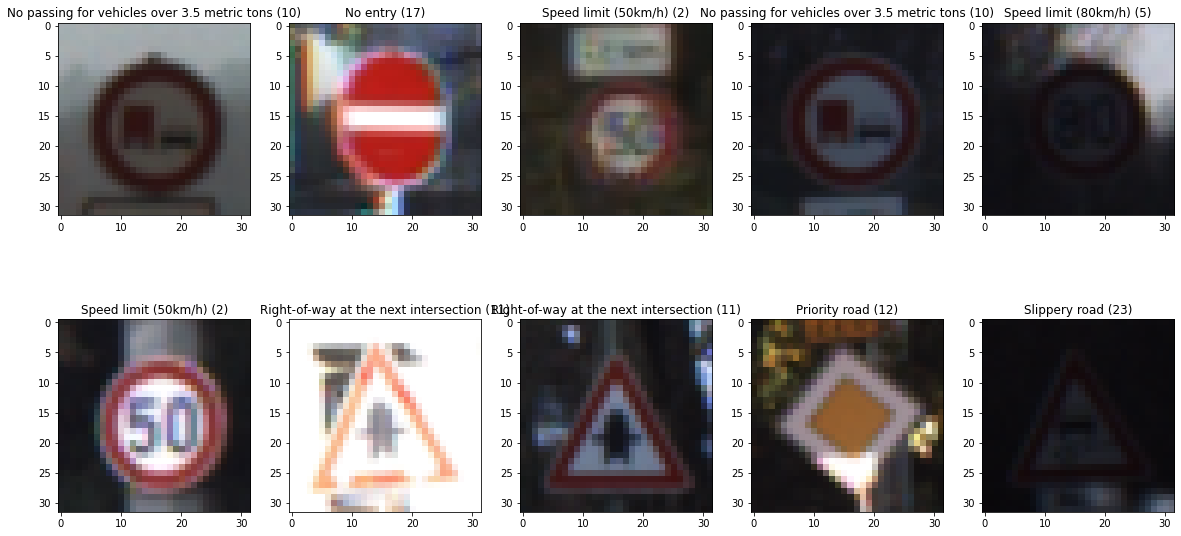

In [5]:
preview_data(X_train, y_train)

Sample validation images

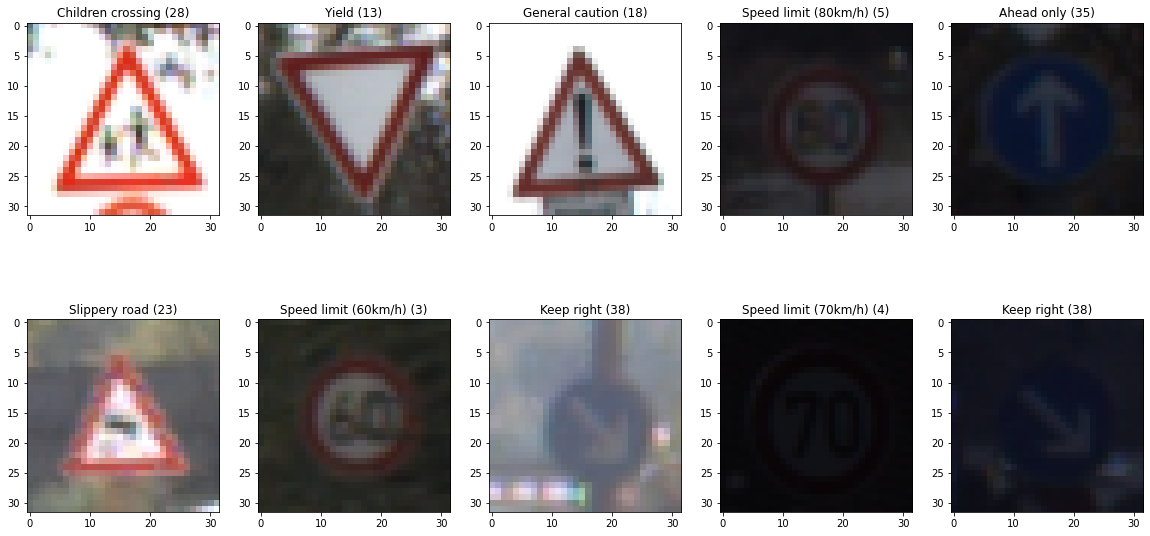

In [6]:
preview_data(X_valid, y_valid)

Sample test images

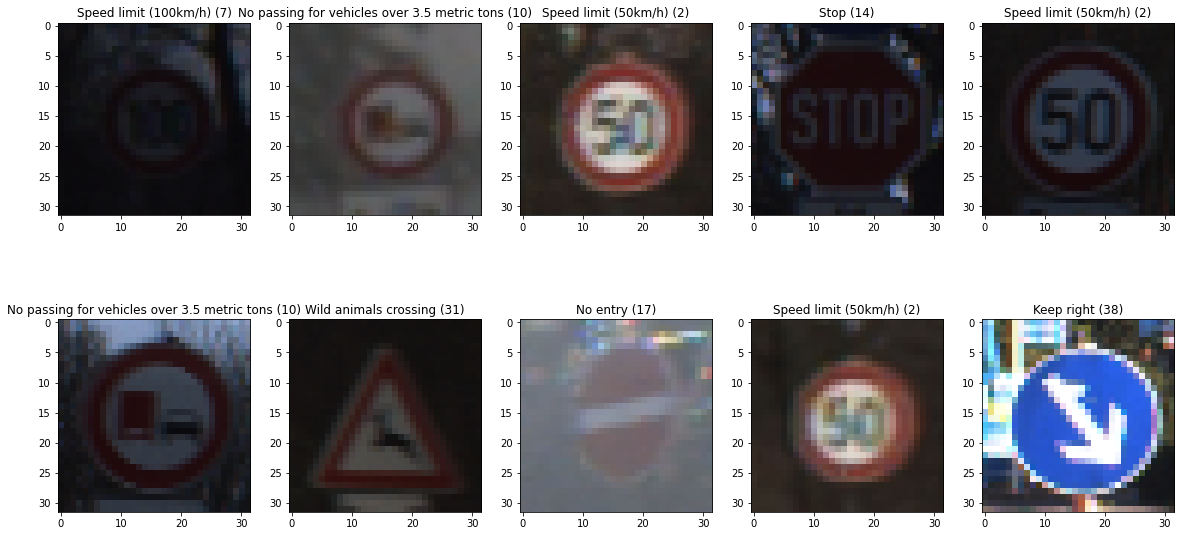

In [7]:
preview_data(X_test, y_test)

Have a look at the distrinution of classes between the three data sets

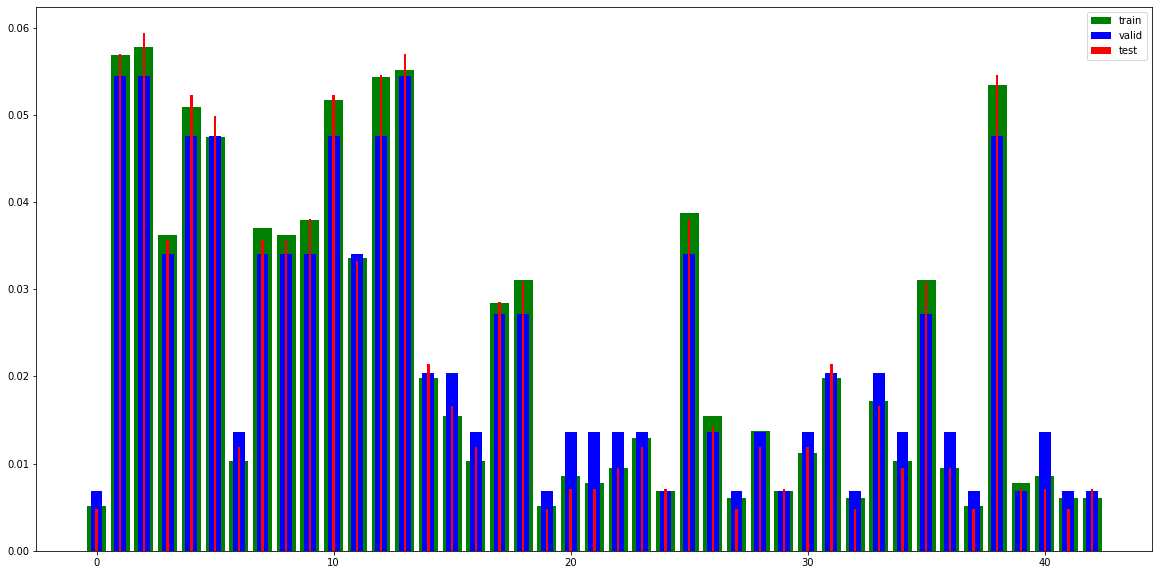

In [8]:
plt.figure(figsize=(20, 10))
plt.bar(range(n_classes), np.bincount(y_train)/n_train, width=0.8, align='center', color='g', label='train')
plt.bar(range(n_classes), np.bincount(y_valid)/n_validation, width=0.5, align='center', color='b', label='valid')
plt.bar(range(n_classes), np.bincount(y_test)/n_test, width=0.1,align='center', color='r', label='test')
plt.legend()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The model used is the LeNet-5 implementation shown in the [classroom] (https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) but implemented with the Keras api.

With the LeNet-5 solution from the lecture, the expected validation set accuracy is about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. 

In [9]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Normalization

normalizer = Normalization(axis=-1)
normalizer.adapt(tf.image.rgb_to_grayscale(X_train))

def pre_process(data):
    # try an implement pre-processing as part of the model itself
    result = tf.image.rgb_to_grayscale(data)
    result = normalizer(result)
    
    return result


# quick test to see all is ok
normalized_train = pre_process(X_train)
print(f'Variance {np.var(normalized_train)} and mean {np.mean(normalized_train)}')

Variance 1.0000008344650269 and mean 3.5626788186249314e-09


One-hot encode our labels

In [10]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, n_classes)
y_valid = to_categorical(y_valid, n_classes)
y_test = to_categorical(y_test, n_classes)

### Model Architecture

In [11]:
def get_model():
    
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = pre_process(inputs)
    
    x = tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(120, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(84, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Image augmentation

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    brightness_range=(0.8, 1.2),
    zoom_range=0.3,
    rotation_range=10,
    # image shifting did not help the model
    #width_shift_range=0.1,
    #height_shift_range=0.1,
)

datagen.fit(X_train)

Preview the image augmentation pipeline, make sure we get what we expect

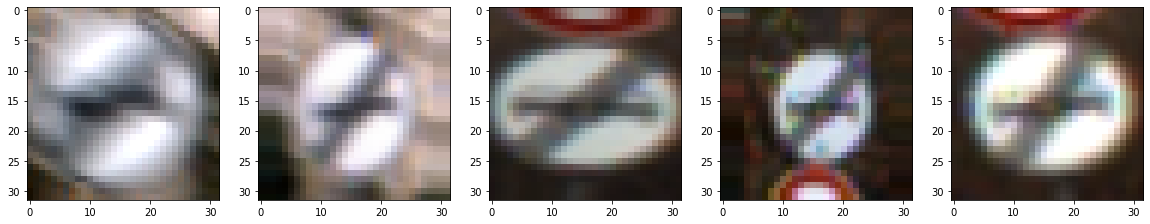

In [26]:
count = 0
fig, axes = plt.subplots(1, 5, figsize=(20,10))
for x_batch, y_batch in datagen.flow(X_train[:100], y_train[:100], batch_size=20):
    axes[count].imshow(x_batch[0]/255)
    count +=1
    if count == 5:
        break

#### Learning rate scheduling

In [20]:
def lr_scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

#### Training loop

In [21]:
epochs = 70
batch_size = 128

model = get_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

model.fit(
    datagen.flow(X_train, y_train, batch_size), 
    steps_per_epoch=len(X_train) / batch_size, 
    validation_data=(X_valid, y_valid), 
    epochs=epochs, batch_size=batch_size,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)])

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_Identity_4 (TensorF [(None, 32, 32, 3)]  0           input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Shape_2 (TensorFlow [(4,)]               0           tf_op_layer_Identity_4[0][0]     
__________________________________________________________________________________________________
tf_op_layer_GatherV2_4 (TensorF [(3,)]               0           tf_op_layer_Shape_2[0][0]        
_______________________________________________________________________________________

272/271 [==============================] - 14s 53ms/step - loss: 0.4670 - categorical_accuracy: 0.8543 - top_k_categorical_accuracy: 0.9810 - val_loss: 0.2719 - val_categorical_accuracy: 0.9338 - val_top_k_categorical_accuracy: 0.9939
Epoch 10/70
272/271 [==============================] - 14s 52ms/step - loss: 0.4459 - categorical_accuracy: 0.8626 - top_k_categorical_accuracy: 0.9833 - val_loss: 0.2483 - val_categorical_accuracy: 0.9367 - val_top_k_categorical_accuracy: 0.9952at
Epoch 11/70
272/271 [==============================] - 14s 52ms/step - loss: 0.4135 - categorical_accuracy: 0.8720 - top_k_categorical_accuracy: 0.9842 - val_loss: 0.2305 - val_categorical_accuracy: 0.9417 - val_top_k_categorical_accuracy: 0.9925
Epoch 12/70
272/271 [==============================] - 14s 52ms/step - loss: 0.4054 - categorical_accuracy: 0.8774 - top_k_categorical_accuracy: 0.9846 - val_loss: 0.2290 - val_categorical_accuracy: 0.9501 - val_top_k_categorical_accuracy: 0.9923
Epoch 13/70
272/271 [=

272/271 [==============================] - 14s 52ms/step - loss: 0.2074 - categorical_accuracy: 0.9371 - top_k_categorical_accuracy: 0.9942 - val_loss: 0.1117 - val_categorical_accuracy: 0.9730 - val_top_k_categorical_accuracy: 0.9957
Epoch 42/70
272/271 [==============================] - 14s 51ms/step - loss: 0.2114 - categorical_accuracy: 0.9377 - top_k_categorical_accuracy: 0.9934 - val_loss: 0.1429 - val_categorical_accuracy: 0.9596 - val_top_k_categorical_accuracy: 0.9937
Epoch 43/70
272/271 [==============================] - 14s 51ms/step - loss: 0.1989 - categorical_accuracy: 0.9404 - top_k_categorical_accuracy: 0.9935 - val_loss: 0.1205 - val_categorical_accuracy: 0.9685 - val_top_k_categorical_accuracy: 0.9955
Epoch 44/70
272/271 [==============================] - 14s 51ms/step - loss: 0.1941 - categorical_accuracy: 0.9434 - top_k_categorical_accuracy: 0.9941 - val_loss: 0.1097 - val_categorical_accuracy: 0.9685 - val_top_k_categorical_accuracy: 0.9950
Epoch 45/70
272/271 [===

---

## Step 3: Test a Model on New Images

To have more insight into how the model is working, we need to download at least five pictures of German traffic signs from the web and use the model to predict the traffic sign type.

#### Image pre-processing

In [29]:
import cv2

def center_crop_resize(img, dim):
    """
    crop the center of the image and resize it to our target dimension
    """
    width, height = img.shape[1], img.shape[0]

    crop_size = int(min(width, height)/2)
    mid_x, mid_y = int(width/2), int(height/2)
    
    crop_img = img[mid_y-crop_size:mid_y+crop_size, mid_x-crop_size:mid_x+crop_size]
    resized = cv2.resize(crop_img, dim)
    return resized

### Load and Output the Images

In [30]:
import urllib.request
import cv2

new_img_links = {
    'https://upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Zeichen_206_-_Halt%21_Vorfahrt_gew%C3%A4hren%21_StVO_1970.svg/32px-Zeichen_206_-_Halt%21_Vorfahrt_gew%C3%A4hren%21_StVO_1970.svg.png': 14,
    'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/STOP_sign.jpg/32px-STOP_sign.jpg': 14,
    'https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Zeichen_274-60_-_Zul%C3%A4ssige_H%C3%B6chstgeschwindigkeit%2C_StVO_2017.svg/32px-Zeichen_274-60_-_Zul%C3%A4ssige_H%C3%B6chstgeschwindigkeit%2C_StVO_2017.svg.png': 3,
    'https://upload.wikimedia.org/wikipedia/commons/thumb/5/5e/Zeichen_276_-_%C3%9Cberholverbot_f%C3%BCr_Kraftfahrzeuge_aller_Art%2C_StVO_1992.svg/32px-Zeichen_276_-_%C3%9Cberholverbot_f%C3%BCr_Kraftfahrzeuge_aller_Art%2C_StVO_1992.svg.png': 9,
    'https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/Zeichen_215_-_Kreisverkehr%2C_StVO_2000.svg/32px-Zeichen_215_-_Kreisverkehr%2C_StVO_2000.svg.png': 40,
    'https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Zeichen_306_-_Vorfahrtstra%C3%9Fe%2C_StVO_1970.svg/32px-Zeichen_306_-_Vorfahrtstra%C3%9Fe%2C_StVO_1970.svg.png': 12,
    'https://upload.wikimedia.org/wikipedia/commons/f/f9/Give_way_outdoor.jpg': 13,
    'https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/Zeichen_205_-_Vorfahrt_gew%C3%A4hren%21_StVO_1970.svg/32px-Zeichen_205_-_Vorfahrt_gew%C3%A4hren%21_StVO_1970.svg.png': 13,
    'https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Zeichen_214_-_Vorgeschriebene_Fahrtrichtung%2C_Geradeaus_oder_rechts%2C_StVO_2017.svg/32px-Zeichen_214_-_Vorgeschriebene_Fahrtrichtung%2C_Geradeaus_oder_rechts%2C_StVO_2017.svg.png': 36
}

def load_img(img_link, target_size=(32, 32)):
    data = np.asarray(bytearray(urllib.request.urlopen(img_link).read()), dtype="uint8")
    img = cv2.imdecode(data, -1)
    
    if img.shape[2] == 4 :
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # resize if needed
    if img.size != target_size:
        img = center_crop_resize(img, target_size)
    
    return img

X_test_web  = np.array([load_img(link) for link in new_img_links.keys()])
y_test_web  = to_categorical(list(new_img_links.values()), n_classes)

print(X_test_web.shape, y_test_web.shape)

(9, 32, 32, 3) (9, 43)


### Predict the Sign Type for Each Image

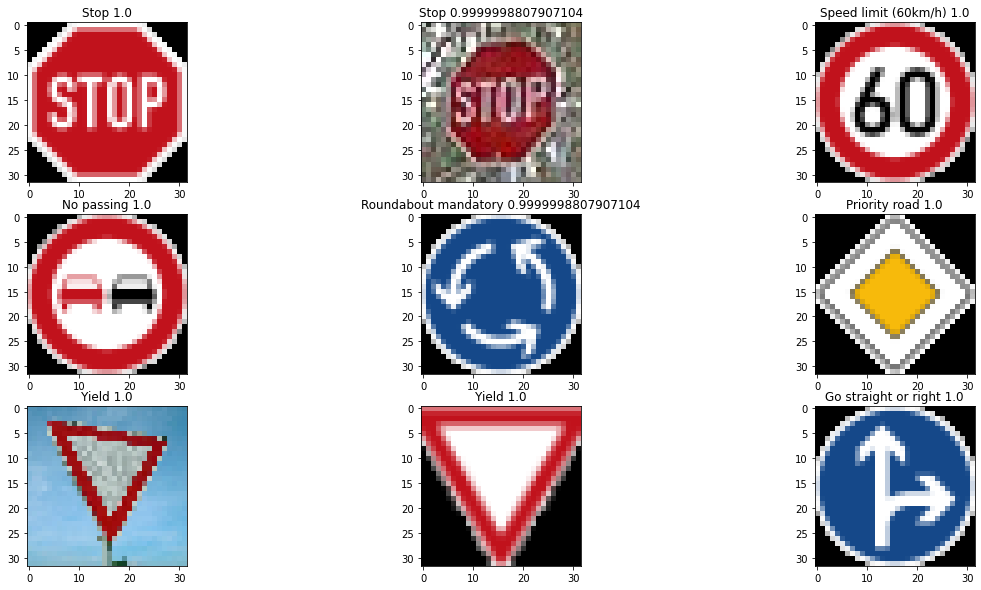

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(20,10))

for img, label_id, ax in zip(X_test_web, y_test_web, [b for a in axes for b in a]):
    prediction = model.predict(np.expand_dims(img, axis=0))
    class_id = np.argmax(prediction)
    label =  get_label(class_id)
    confidence = np.max(prediction)
    ax.imshow(img)
    ax.set_title(f'{label} {confidence}')

### Analyze Performance

Compute the simple and top-5 accuracy

In [32]:
def sample_from_train(label_id):
    one_hot = to_categorical(label_id, n_classes)
    matches = [i for i,l in enumerate(y_train) if (l == one_hot).all()]
    return X_train[np.random.choice(matches)]

def show_top_k(img, k=5):
    prediction = model.predict(np.expand_dims(img, axis=0))[0]
    top = np.argsort(prediction)[::-1][:k]
    #print([get_label(label_id) for label_id in top])
    samples = [sample_from_train(i) for i in top]
    fig, axes = plt.subplots(1, k+1, figsize=(20,10))
    axes[0].imshow(img)
    axes[0].set_title(f'Original')
    for i, ax in enumerate(axes[1:]):
        label =  get_label(top[i])
        ax.imshow(samples[i])
        ax.set_title(f'{label} {prediction[top[i]]:.5f}')

In [33]:
[loss, accuracy, top_k_accuracy] = model.evaluate(X_test_web, y_test_web)
print(f'\nAccuracy is {accuracy*100}% while Top 5 accuracy is {top_k_accuracy*100}% !')

1/1 [==============================] - 0s 1ms/step - loss: 2.6491e-08 - categorical_accuracy: 1.0000 - top_k_categorical_accuracy: 1.0000

Accuracy is 100.0% while Top 5 accuracy is 100.0% !


For each image from web we compare the original with training samples for the top 5 predictions.

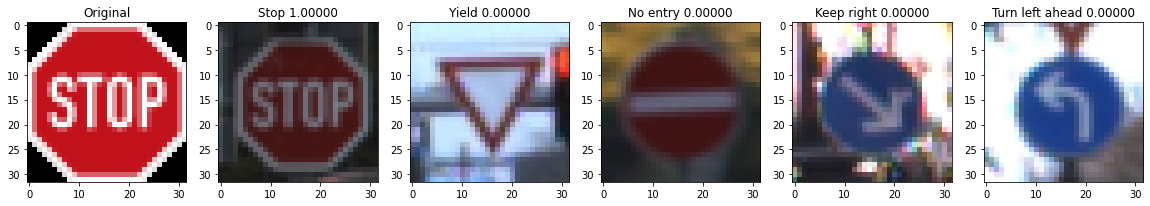

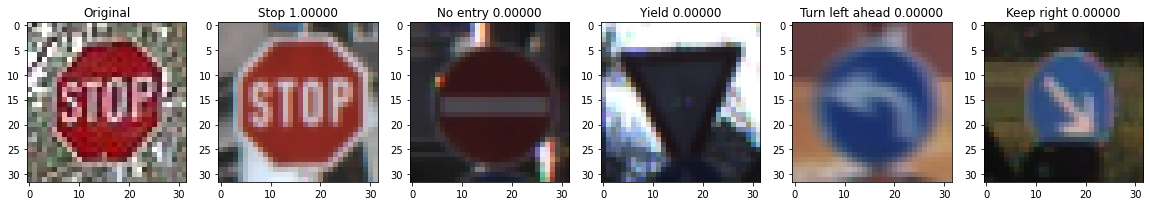

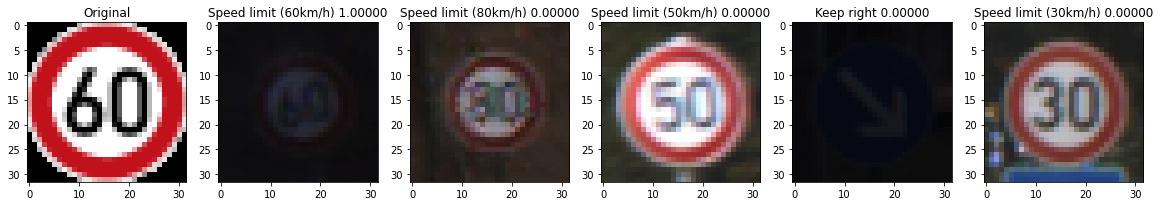

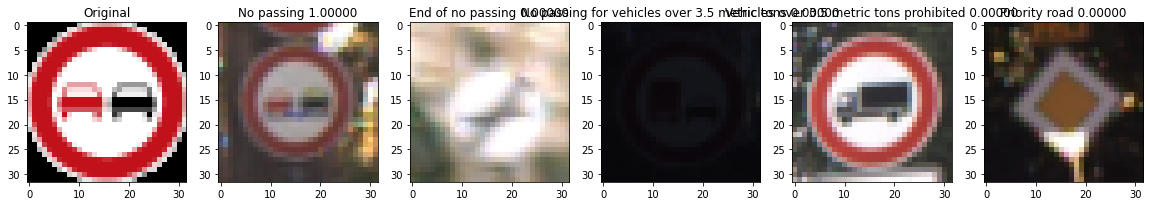

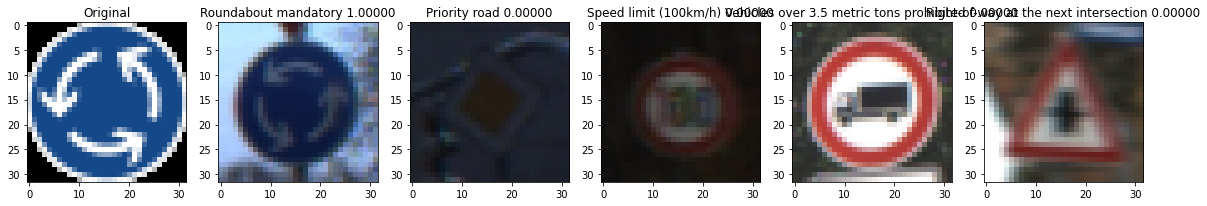

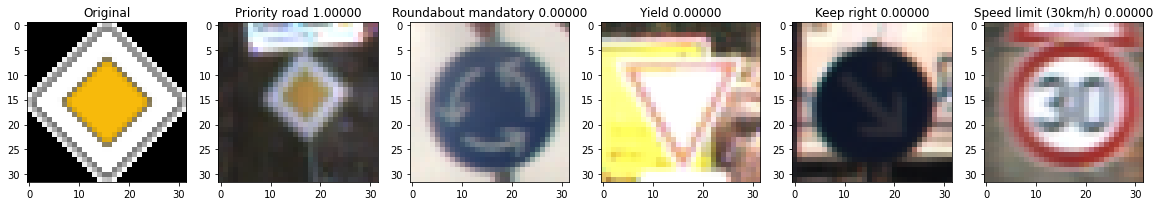

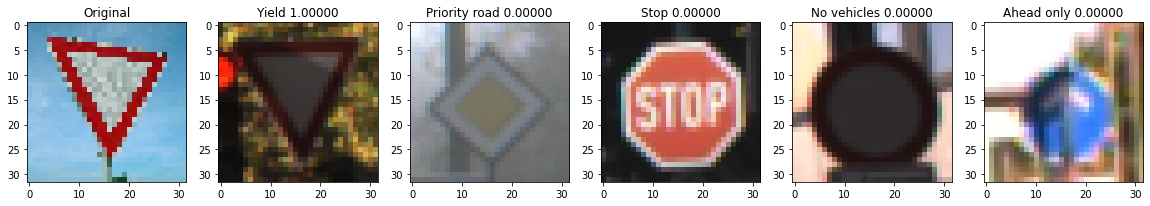

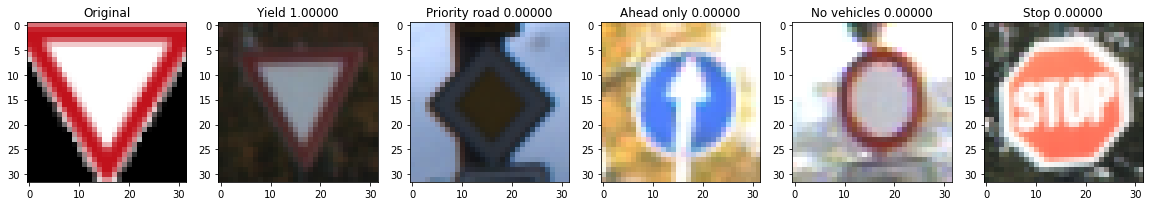

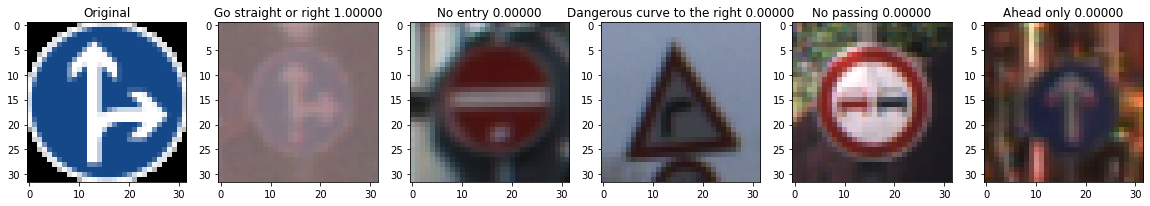

In [34]:
for img in X_test_web:
    show_top_k(img)

## Visualize the Neural Network's State with Test Images

In [35]:
def show_features(img):
    layer_outputs = [(layer.name, layer.output) for layer in model.layers if any(key in layer.name for key in ['conv', 'pool'])]
    
    print(layer_outputs)
    # new model with an output for each layer we want to preview
    feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=[l[1] for l in layer_outputs])
    
    # get features for our image
    feature_maps = feature_map_model.predict(np.expand_dims(img, axis=0))
    
    for idx, feature_map in enumerate(feature_maps):
        channels = feature_map.shape[-1]
        fig, axes = plt.subplots(1, channels, figsize=(20,2))
        fig.suptitle(f'{layer_outputs[idx][0]} {feature_map.shape}')
        for i, ax in enumerate(axes):
            preview = feature_map[0, :, :, i]
            preview-= preview.mean()
            preview/= preview.std ()
            preview*=  64
            preview+= 128
            preview= np.clip(preview, 0, 255).astype('uint8')
            ax.imshow(preview)

Preview all channels of some of the layers of the model for two of the web images to get a feeling on the learned features

[('conv2d_4', <tf.Tensor 'conv2d_4/Relu:0' shape=(None, 28, 28, 6) dtype=float32>), ('max_pooling2d_4', <tf.Tensor 'max_pooling2d_4/MaxPool:0' shape=(None, 14, 14, 6) dtype=float32>), ('conv2d_5', <tf.Tensor 'conv2d_5/Relu:0' shape=(None, 10, 10, 16) dtype=float32>), ('max_pooling2d_5', <tf.Tensor 'max_pooling2d_5/MaxPool:0' shape=(None, 5, 5, 16) dtype=float32>)]


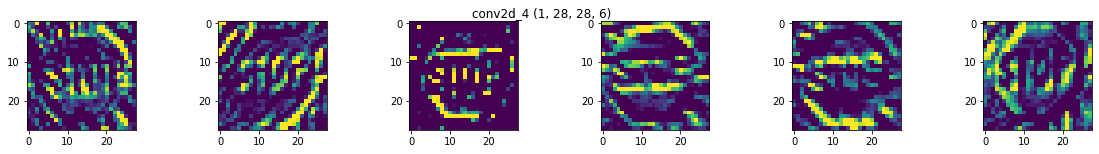

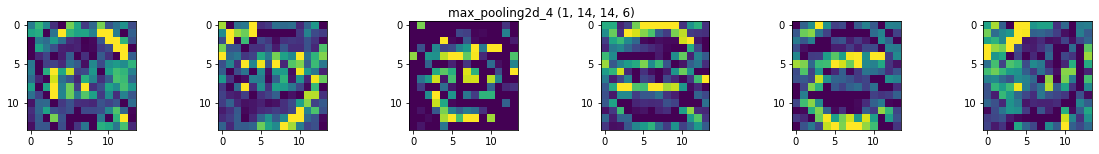

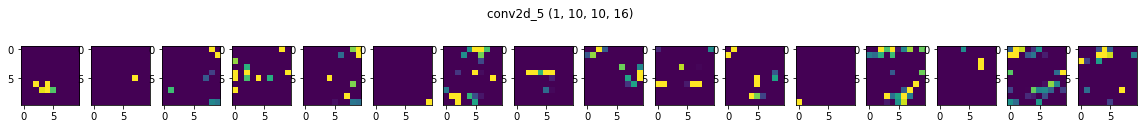

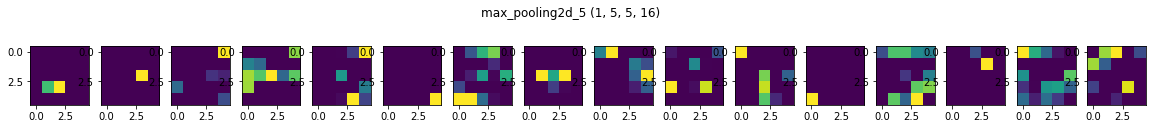

In [36]:
show_features(X_test_web[1])

[('conv2d_4', <tf.Tensor 'conv2d_4/Relu:0' shape=(None, 28, 28, 6) dtype=float32>), ('max_pooling2d_4', <tf.Tensor 'max_pooling2d_4/MaxPool:0' shape=(None, 14, 14, 6) dtype=float32>), ('conv2d_5', <tf.Tensor 'conv2d_5/Relu:0' shape=(None, 10, 10, 16) dtype=float32>), ('max_pooling2d_5', <tf.Tensor 'max_pooling2d_5/MaxPool:0' shape=(None, 5, 5, 16) dtype=float32>)]


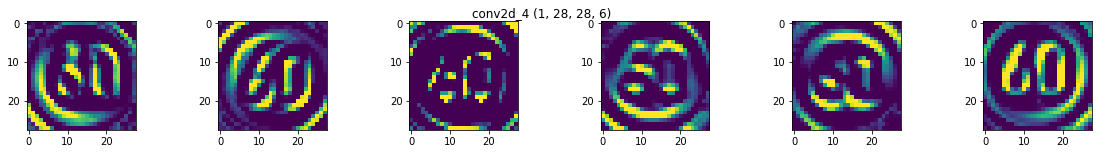

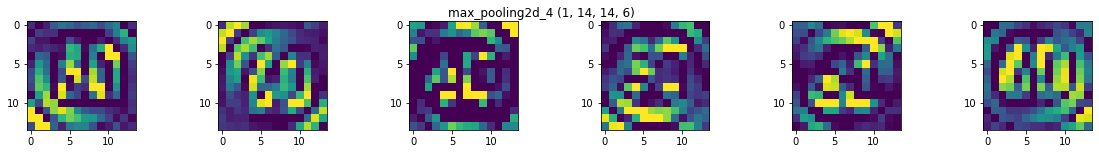

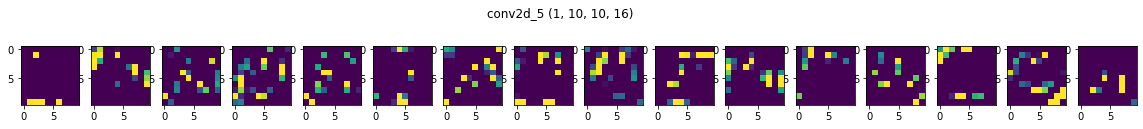

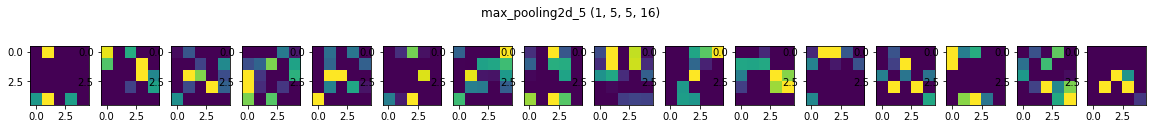

In [37]:
show_features(X_test_web[2])

In [ ]:
import matplotlib.cm as cm

classifier_layer_names=['max_pooling2d_19','flatten_8', 'dense_27', 'dense_28', 'dense_29']
last_conv_layer_name='conv2d_23'

def make_gradcam_heatmap(img):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(np.expand_dims(img, axis=0))
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.7 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(20,10))

for img, ax in zip(X_test_web, [b for a in axes for b in a]):
    ax.imshow(make_gradcam_heatmap(img))

As a final step, once we are confident with the performance of our model, and the intuition behind its decisions, we can compute the accuracy on the test set, which in this case represents our real world scenario

In [25]:
[loss, accuracy, top_k_accuracy] = model.evaluate(X_test, y_test)

395/395 [==============================] - 1s 2ms/step - loss: 0.1776 - categorical_accuracy: 0.9568 - top_k_categorical_accuracy: 0.9939
